In [866]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts
from numpy import random as rnd
from pylcp.common import progressBar
import pandas as pd


In [867]:
def v_avg(m,T):
    return np.sqrt(8*cts.k*T/(np.pi*m))

In [868]:

klab = 2*np.pi*25068.2222# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v0 = v_avg(mass_lab,216.85)
Blab = (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
# T # About 15 G/cm is a typical gradient for Rb
L = 100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) + 5
print(Blab, L,v0)

0.02917801968146881 9.756373438101187 162.90852496567848


In [869]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # cm
t0 = 1/gammalab  # s

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
l = L/x0 

print(x0, t0, mass, k, gamma, alpha)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 13.295047898996732


In [870]:
def mag(R):
    if any(R >l):
      return np.zeros(rateeq.hamiltonian.n)
    else: 
        return alpha*(1-np.sqrt(1-R/l))

In [919]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 1,  1.3426,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035, 1.3426,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)


dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
vc = x0/t0*1/(100)
det = v0/vc
s = 1.5

# Define the laser beams:
laserBeams = pylcp.laserBeams([
     {'kvec':np.array([-1., 0., 0.]), 's':1.5, 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) - det*gamma}],
    beam_type=pylcp.infinitePlaneWaveBeam)

# Define the magnetic field:
linGrad = lambda R: mag(R)

In [920]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=False)

In [921]:
len(x)
len(v)

49

In [922]:

x = np.arange(0, L, 0.004)/(x0)
v = np.arange(0, 300,4100/1000)/vc


X, V = np.meshgrid(x, v)

Rvec = np.array([X, np.zeros(X.shape), np.zeros(X.shape)])
Vvec = np.array([V, np.zeros(V.shape), np.zeros(V.shape)])

rateeq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)

c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Rijl[key][ll] = gamma*intensity/2*\


Completed in 2:32.                                                  


C:\Users\benfo\AppData\Local\Temp\ipykernel_15844\3906648405.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('viridis_r')


Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

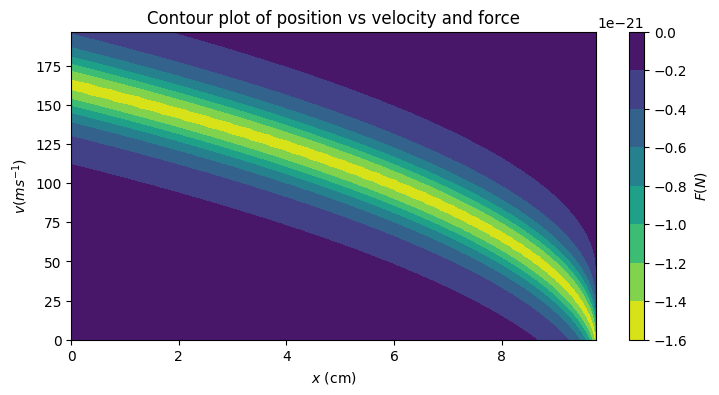

In [898]:
fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab
im1 = ax.contourf(np.array(x)*x0, np.array(v)*vc, rateeq.profile['Fx'].F[0]*Fc, cmap =cmap_reversed)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')

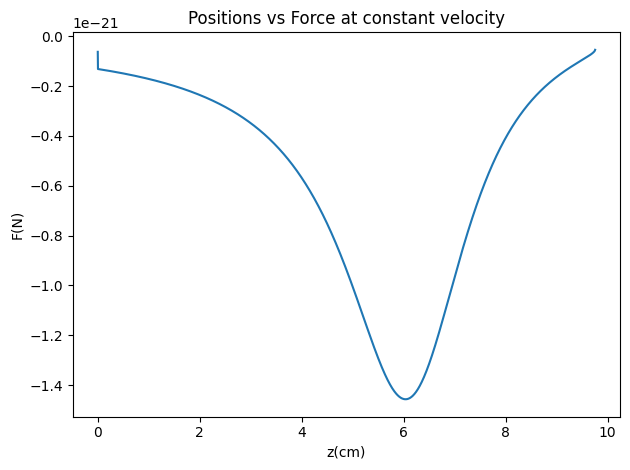

In [899]:
fig, ax = plt.subplots(nrows=1, ncols=1, num="Expression",sharey = False)
const = x0**3/cts.hbar*t0**3
ax.plot(np.array(x)*x0, rateeq.profile['Fx'].F[0][int(len(v)/2),:]*Fc)
ax.set_xlabel('z(cm)')
ax.set_ylabel('F(N)')
plt.title('Positions vs Force at constant velocity')
plt.tight_layout()

In [877]:
len(v)/2*vc

300.2064296406417

In [ ]:
# %% Now try to evolve some initial state!

rateeq.v0 = np.array([140/vc, 0., 0.])
rateeq.r0 = ([0,0,0])
n0 = np.zeros(rateeq.hamiltonian.n)
n0[0] = 1
rateeq.set_initial_pop(n0)

t_span = [0, 0.0013/t0]


rateeq.evolve_motion(t_span,
                  progress_bar=True,
                  random_recoil=False
                 );

AttributeError: 'NoneType' object has no attribute 't'

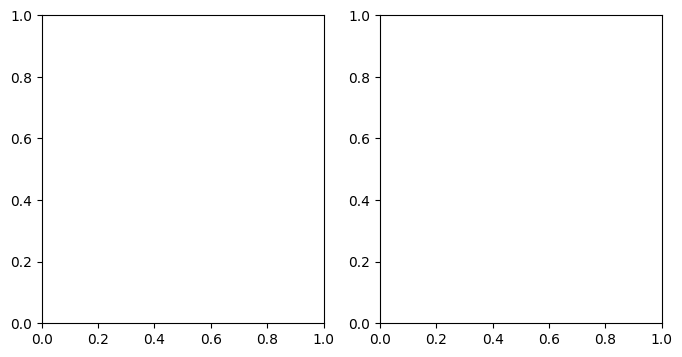

In [923]:
fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(rateeq.sol.t*t0*1e3,rateeq.sol.r[0]*x0)
ax[1].plot(rateeq.sol.t*t0*1e3,rateeq.sol.v[0]*vc)
ax[0].set_xlabel('t (ms)')
ax[0].set_ylabel('z (cm)')
ax[1].set_xlabel('t (ms)')
ax[1].set_ylabel('v (m/s)')
ax[1].yticks = np.arange(0, 200, 100)
plt.tight_layout()

In [880]:
# import numpy as np

# # Assuming vc, v0, t0, rateeq, etc., are defined elsewhere in your code

# sol_v = []
# sol_r = []
# sol_t = []
# t_span = [0, 0.0013/t0]  # Define the time span for the evolution
# j = 0

# # Generate velocities with a normal distribution
# velocities = np.random.normal(v0, 10, 100)
# rounded_velocities = np.round(velocities, 3) / vc  # Round and normalize velocities

# # Define a reasonable velocity threshold to avoid extreme cases
# velocity_threshold = 10 * v0  # You can adjust this threshold

# for i in range(100):  # Loop over 100 atoms
#     print(j)

#     # Check if the velocity is within a reasonable range
#     if np.abs(velocities[i]) > velocity_threshold:
#         print(f"Skipping atom {j} due to extreme velocity: {velocities[i]}")
#         j += 1
#         continue

#     try:
#         # Set initial velocity and position for rate equations
    #     rateeq.v0 = np.array([rounded_velocities[i], 0., 0.])  # x-velocity only
    #     rateeq.r0 = [0, 0, 0]  # Initial position

    #     # Set the initial population in the Hamiltonian
    #     n0 = np.zeros(rateeq.hamiltonian.n)
    #     n0[0] = 1  # Assume initial population in ground state
    #     rateeq.set_initial_pop(n0)

    #     # Evolve the motion over the time span
    #     rateeq.evolve_motion(t_span,
    #                          progress_bar=True,
    #                          random_recoil=False)

    #     # Append the resulting velocity and position to the solution lists
    #     sol_v.append(rateeq.sol.v[0])
    #     sol_r.append(rateeq.sol.r[0]) 
    #      # Append final velocity in x-direction
    #     sol_t.append(rateeq.sol.t)  # Append final position in x-direction

    # except Exception as e:
    #     print(f"Error evolving atom {j}: {e}")  # Handle any evolution errors

    # j += 1
    



In [881]:
f_d = []
for i in range(len(rateeq.profile['Fx'].F[0])):
    for j in range(len(x)):
        f_d.append([v[i],x[j],rateeq.profile['Fx'].F[0][i][j]])

In [882]:
v_d = []
x_d = []
ff_d = []
for i in f_d:
    v_d.append(i[0]*vc)
    x_d.append(i[1]*x0)
    ff_d.append(i[2]*Fc)


In [883]:
def find_nearest_value(lst, target):
    nearest = min(lst, key=lambda x: abs(x - target))
    return nearest


In [884]:
data = {'Velocity(ms^-1)': v_d, 'Position(cm)': x_d, 'Force(N)': ff_d}
df = pd.DataFrame(data)

In [885]:
L

9.756373438101187

In [916]:
t_max = 0.14
dt = t_max/10000
t_span = np.linspace(0,t_max,10000)
x_t = []
v_t = []
s_0  = 0
v_0 = 200
v_ind = list(np.array(v)*vc)
x_ind = list(np.array(x)*x0)
j = 0
s = 0

for i in range(len(t_span)):
    
    c = v_ind.index(find_nearest_value(v_ind,v_0))
    d = x_ind.index(find_nearest_value(x_ind,s))
    a = ((rateeq.profile['Fx'].F[0][c][d])*Fc)/mass_lab
    s = (1/2)*a*(dt**2) + v_0*dt + s
    v_0 = v_0 + a*dt
    x_t.append(s)
    v_t.append(v_0)
    j = t_span[i]
 

In [918]:
a = (rateeq.profile['Fx'].F[0][c][d]*Fc)/mass_lab
print(a)

-69.21702037513224


In [948]:
l

10000

In [949]:
import numpy as np
v0 = v0 = v_avg(mass_lab,216.85)
t_max = 0.14
dt = t_max / 10000
t_span = np.linspace(0, t_max, 10000)
x_d = np.arange(0,L,0.004)
x_t = []
v_t = []
s_0 = 0
v_0 = v0

# Assuming `v` and `x` are arrays or lists that are defined earlier
v_ind = list(np.array(v) * vc)
x_ind = list(np.array(x_d) * x0)

s = 0

for i in range(len(t_span)):
    # Find the nearest velocity and displacement
    dt = t_span[i] - j
    c = v_ind.index(find_nearest_value(v_ind, v_0))
    d = x_ind.index(find_nearest_value(x_ind, s))
    
    # Calculate acceleration using the force profile
    a = (rateeq.profile['Fx'].F[0][c][d]*Fc) / mass_lab
    
    # Update position using SUVAT (s = ut + 1/2 at^2)
    s = (1 / 2) * a * (dt ** 2) + v_0 * dt + s
    
    # Update velocity (v = u + at)
    v_0 = v_0 + a * dt
    
    # Append position and velocity to lists
    x_t.append(s)
    v_t.append(v_0)

    # You can keep track of time if needed, j is currently unused
    j = t_span[i]


In [942]:
max(x_ind)

9.756

In [937]:
rateeq.profile['Fx'].F[0][c][d]*Fc

-9.758343053652668e-25

In [889]:
for i in range(len(t_span)):
    t = t_span[i] - j
    print(t)
    print((t_span[i],1))
 

-0.14
(0.0, 1)
-0.13998599859986
(1.4001400140014004e-05, 1)
-0.13997199719971998
(2.8002800280028007e-05, 1)
-0.13995799579957996
(4.200420042004201e-05, 1)
-0.13994399439943997
(5.6005600560056014e-05, 1)
-0.13992999299929995
(7.000700070007002e-05, 1)
-0.13991599159915993
(8.400840084008402e-05, 1)
-0.13990199019901992
(9.800980098009802e-05, 1)
-0.1398879887988799
(0.00011201120112011203, 1)
-0.13987398739873988
(0.00012601260126012602, 1)
-0.13985998599859986
(0.00014001400140014003, 1)
-0.13984598459845987
(0.00015401540154015404, 1)
-0.13983198319831985
(0.00016801680168016805, 1)
-0.13981798179817984
(0.00018201820182018206, 1)
-0.13980398039803982
(0.00019601960196019604, 1)
-0.1397899789978998
(0.00021002100210021005, 1)
-0.13977597759775978
(0.00022402240224022406, 1)
-0.13976197619761976
(0.00023802380238023807, 1)
-0.13974797479747977
(0.00025202520252025205, 1)
-0.13973397339733976
(0.0002660266026602661, 1)
-0.13971997199719974
(0.00028002800280028006, 1)
-0.139705970597

Text(0, 0.5, '$v(ms^{-1})$')

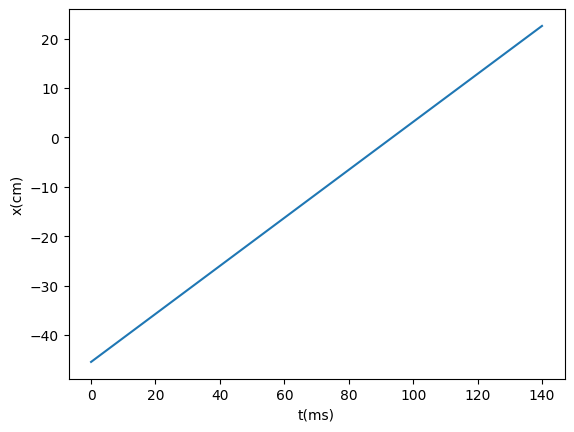

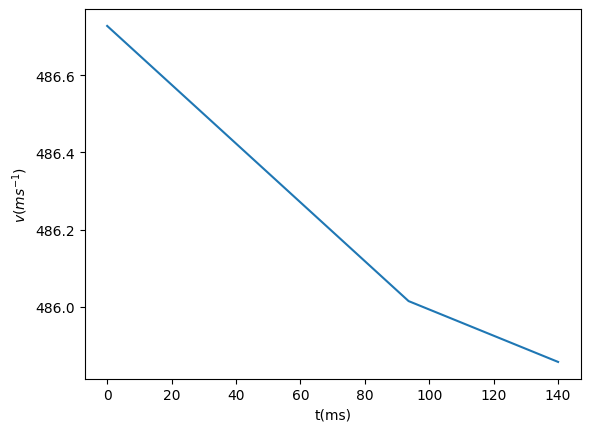

In [950]:
plt.plot(np.array(t_span)*1e3,x_t)
plt.xlabel('t(ms)')
plt.ylabel('x(cm)')
plt.figure()
plt.plot(np.array(t_span)*1e3,v_t)
plt.xlabel('t(ms)')
plt.ylabel('$v(ms^{-1})$')

In [933]:
v0

162.90852496567848

In [892]:
max(x_t)

9.418443868402601